# Predict next N time series value with LSTM + Lineal

* https://www.crosstab.io/articles/time-series-pytorch-lstm
* https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset
* https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random

import torch
from torch import nn
from torch.nn import MSELoss
from torch.utils.data import DataLoader

import pytorch_common.util    as pu
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel

from pytorch_common.callbacks.output import OutputHook

from pytorch_common.modules import PredictMixin, FitMixin


from data   import SequenceDataset, \
                   standarizer, \
                   variable_to_sequences, \
                   features_target_split, \
                   train_test_split
from util   import set_seed, \
                   loss_wrapper

from module import TimeSeriesPredictor

from scipy import stats
from scipy.signal import savgol_filter

In [4]:
def interpolation_plot(test_dataset, sequence_size, times):
    sns.set(rc = {'figure.figsize':(15,8)})
    feature, _  = test_dataset[0]
    complete_pred_values = feature.squeeze(1).tolist()

    pred_values, true_values = [], []

    for time in range(1, times+1):
        features = complete_pred_values[-sequence_size:]

        input    = torch.tensor(features).unsqueeze(1).unsqueeze(0)

        next_values  = model.predict(input).squeeze(0).cpu().numpy()

        complete_pred_values.append(next_values[0])

        pred_values.append(next_values[0])

        _, y_trues = test_dataset[time]
        true_values.append(y_trues[0])

    plot_pred_true(pred_values, true_values, times)

def plot_pred_true(y_pred, y_true, times):
    sns.set_style("darkgrid")
    plt.plot(y_true[:times], color='green',label="True")        
    plt.plot(y_pred[:times], color='blue', label="Prediction")
    plt.legend()
    plt.show()


def plot(y):
    sns.set_style("darkgrid")
    plt.plot(y, color='green')
    plt.legend()
    plt.show()


## Setup

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
pu.set_device_name('gpu')

In [7]:
pu.get_device()

device(type='cuda', index=0)

In [8]:
torch.cuda.is_available()

True

In [9]:
torch.__version__

'1.12.1+cu116'

In [10]:
sns.set(rc = {'figure.figsize':(8,4)})

In [11]:
set_seed(42)

In [12]:
WEIGHTS_PATH   = '../weights'

WINDOW_SIZE    = 366
sequence_size  = WINDOW_SIZE -1
TARGET_SIZE    = 3

TRAIN          = True
N_WORKERS      = 24
BATCH_SIZE     = 800
n_hidden_units = 100
n_layers       = 2
dropout        = 0
out_features   = TARGET_SIZE
test_percent   = 0.1


DATASET_PATH = '../datasets/consumo_energetico_diario.csv'
VARIABLE     = 'mwh'

## Preprocessing

#### 1. Load dataset.

In [13]:
dataset = pd.read_csv(DATASET_PATH)
dataset.columns = dataset.columns.str.lower()

dataset         = dataset[['dia', VARIABLE]]
dataset['date'] = pd.to_datetime(dataset['dia'], format="%Y-%m-%d")
dataset         = dataset.drop(columns=['dia'])
dataset         = dataset.sort_values(by='date',ascending=True)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5722 entries, 0 to 5721
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   mwh     5722 non-null   float64       
 1   date    5722 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 134.1 KB


In [14]:
dataset.head()

,mwh,date
0,81445.928,2005-12-01
1,81749.888,2005-12-02
2,72134.590,2005-12-03
3,63452.628,2005-12-04
4,81508.078,2005-12-05


In [15]:
dataset.shape

(5722, 2)

/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mwh'>

<Figure size 432x288 with 1 Axes>

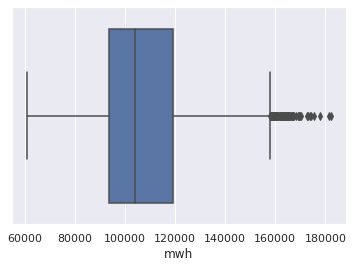

In [16]:
sns.boxplot(dataset[VARIABLE])

In [17]:
dataset['zscore'] = stats.zscore(dataset[VARIABLE].values)
dataset = dataset[dataset['zscore'] < 2.5]
dataset = dataset.sort_values(by='date',ascending=True)
dataset.shape

(5637, 3)

/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mwh'>

<Figure size 432x288 with 1 Axes>

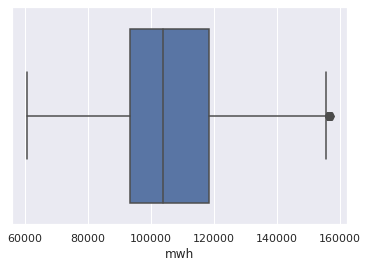

In [18]:
sns.boxplot(dataset[VARIABLE])

In [19]:
# window size 101, polynomial order 3
dataset[VARIABLE] = savgol_filter(dataset[VARIABLE].values, 7, 3) 

dataset = dataset.sort_values(by='date',ascending=True)
dataset[VARIABLE] = dataset[VARIABLE].apply(lambda x: round(x, 1))

2022-09-03 15:31:20,753 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1440x432 with 1 Axes>

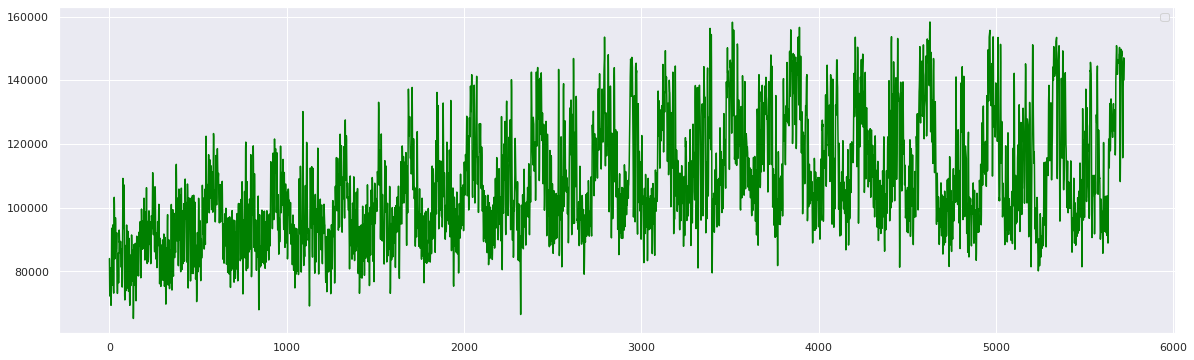

2022-09-03 15:31:20,879 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1440x432 with 1 Axes>

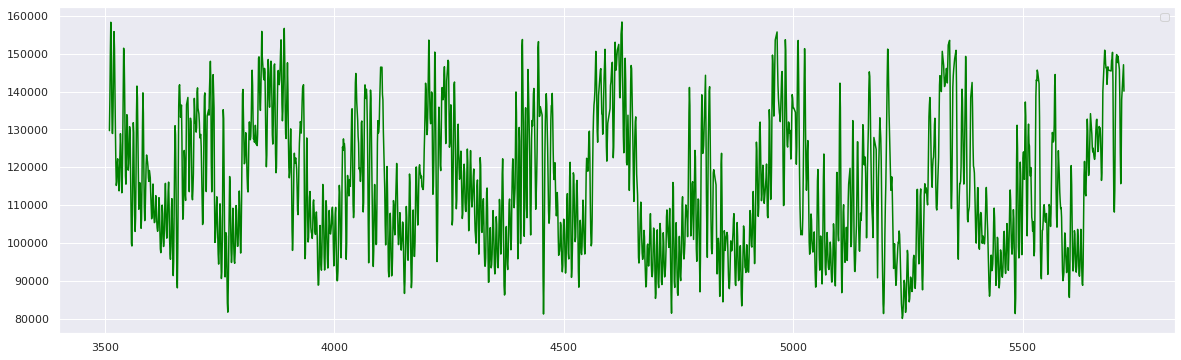

,mwh,date,zscore
0,84040.6,2005-12-01,-1.289570
1,75569.7,2005-12-02,-1.274461
2,72284.8,2005-12-03,-1.752405
3,72759.5,2005-12-04,-2.183955
4,75694.6,2005-12-05,-1.286481


In [20]:
sns.set(rc = {'figure.figsize':(20,6)})
plot(dataset[VARIABLE])
plot(dataset[3500:][VARIABLE])

dataset.head()

#### 2. Train-test splot and normalize data:

In [21]:
selected_dataset = dataset[3500:]

In [22]:
train_set, test_set = train_test_split(selected_dataset, test_percent)

train_set.shape, test_set.shape

((1923, 3), (214, 3))

In [23]:
norm_train_set, norm_test_set = standarizer(train_set, test_set, columns=[VARIABLE])

norm_train_set.shape, norm_test_set.shape

((1923, 4), (214, 4))

In [24]:
norm_train_set.tail()

,mwh,date,zscore,norm_mwh
5488,131113.6,2020-12-10,1.837708,0.971681
5489,125205.3,2020-12-11,0.801391,0.626360
5490,110948.8,2020-12-12,0.034809,-0.206887
5491,99083.5,2020-12-13,-0.841741,-0.900376
5492,96128.0,2020-12-14,-0.210492,-1.073115


In [25]:
norm_test_set.head()

,mwh,date,zscore,norm_mwh
5493,100236.7,2020-12-15,-0.275339,-0.832975
5494,114220.2,2020-12-16,-0.186674,-0.015684
5495,121376.2,2020-12-17,0.760470,0.402561
5496,117802.6,2020-12-18,1.421329,0.193696
5497,108118.2,2020-12-19,-0.104962,-0.372326


#### 3. Separare into sequences using a sliding window.

In [26]:
variable_norm_values = norm_train_set[f'norm_{VARIABLE}']
train_set_sequences  = variable_to_sequences(variable_norm_values, WINDOW_SIZE)
test_set_sequences   = variable_to_sequences(variable_norm_values,  WINDOW_SIZE)

train_set_sequences.shape, test_set_sequences.shape

((1558, 366), (1558, 366))

#### 4. Separate sequences into (features=sequence-1, target=last):

In [27]:
train_features, train_targets = features_target_split(train_set_sequences, target_size=TARGET_SIZE)
test_features,  test_targets  = features_target_split(test_set_sequences, target_size=TARGET_SIZE)

train_features.shape, train_targets.shape, test_features.shape, test_targets.shape

((1558, 363), (1558, 3), (1558, 363), (1558, 3))

In [28]:
torch.tensor(train_features).unsqueeze(2).float().shape

torch.Size([1558, 363, 1])

#### 5. Create a dataset for both train an test sets:

In [29]:
train_dataset = SequenceDataset(train_features, train_targets)
test_dataset  = SequenceDataset(test_features, test_targets)

len(train_dataset), len(test_dataset)

(1558, 1558)

In [30]:
# f, t = train_dataset[0]
# f.shape, t.shape

In [31]:
# f, t = test_dataset[0]
# f.shape, t.shape

#### 6. Create dataloader for both tra and test datasets:

In [32]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

# f, t = next(iter(train_loader))
# f.shape, t.shape

In [33]:
# f, t = next(iter(test_loader))
# f.shape, t.shape

# Model Definition

In [34]:
model = TimeSeriesPredictor(
    n_hidden_units = n_hidden_units, 
    n_layers       = n_layers,
    dropout        = dropout,
    out_features   = out_features
).to(pu.get_device())

model

TimeSeriesPredictor(
  (rnn): LSTM(1, 100, num_layers=2, batch_first=True)
  (hidden_linear): Linear(in_features=100, out_features=100, bias=True)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [35]:
# f, t = next(iter(test_loader))
# f.shape, model(f).shape

# Train

In [36]:
def load(mode, path): model.load_state_dict(torch.load(path))
def save(mode, path): torch.save(mode.state_dict(), path)

In [37]:
# load(model, f'{WEIGHTS_PATH}/lstm-model.h5')

<Figure size 1080x576 with 1 Axes>

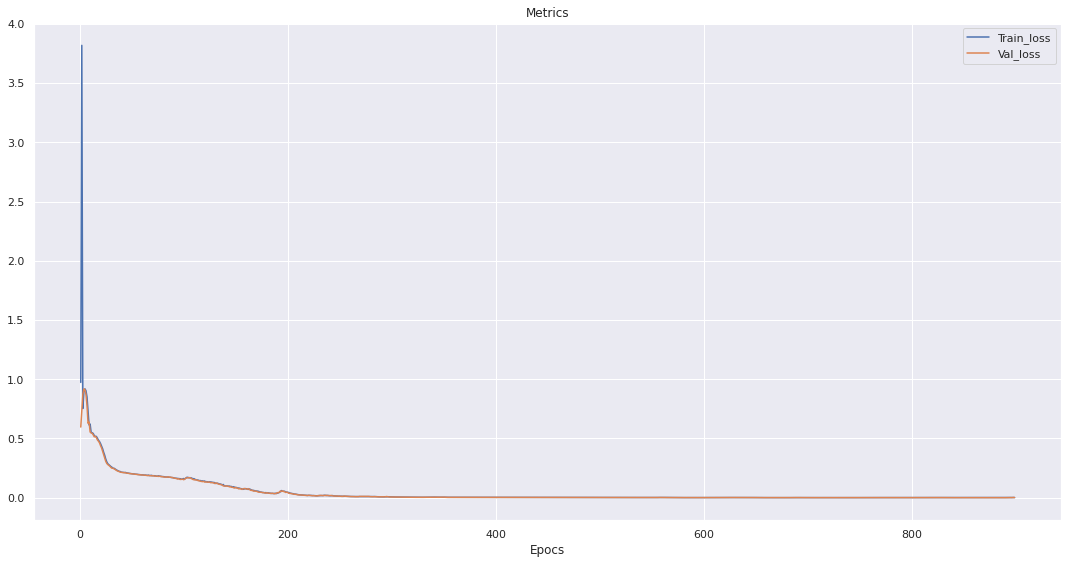

<Figure size 1080x576 with 1 Axes>

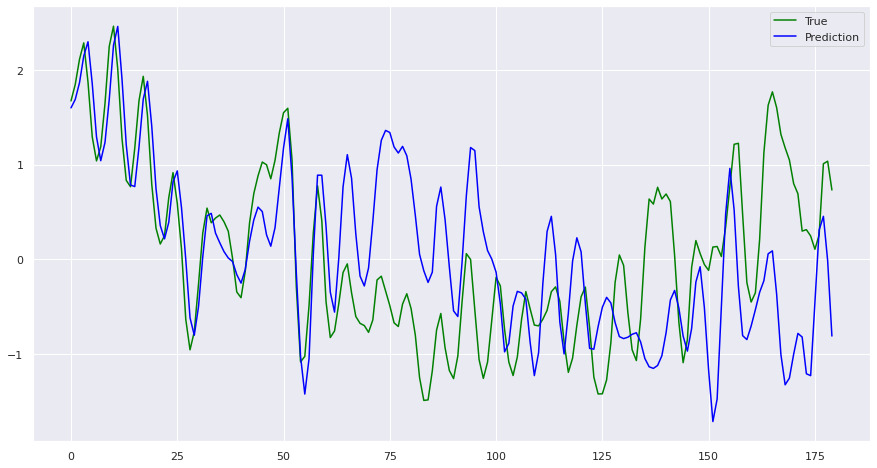

In [38]:
n_epochs = 900

if TRAIN:
    loss_fn = MSELoss()

    learning_rate  = 0.01
    
    model.fit(
        train_loader,
        loss_fn   = loss_fn,
        epochs    = n_epochs,
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr = learning_rate
        ),
        callbacks   = [
            Validation(
                test_loader,
                metrics       = { 'val_loss': loss_wrapper(loss_fn) },
                each_n_epochs = 1
            ),
            Logger(['time', 'epoch', 'train_loss', 'val_loss', 'patience', 'lr']),
            MetricsPlotter(metrics=['train_loss', 'val_loss'],  plot_each_n_epochs=10),
            OutputHook(lambda ctx: interpolation_plot(test_dataset, sequence_size, times=180), plot_each_n_epochs=10),            
            # ReduceLROnPlateau(metric='val_loss', mode='min', patience=lr_patience),
            #, SaveBestModel(metric='val_loss', path=WEIGHTS_PATH, experiment_name='lstm-time-series')
        ]
    )

In [39]:
# save(model, f'{WEIGHTS_PATH}/lstm-model.h5')

<Figure size 1080x576 with 1 Axes>

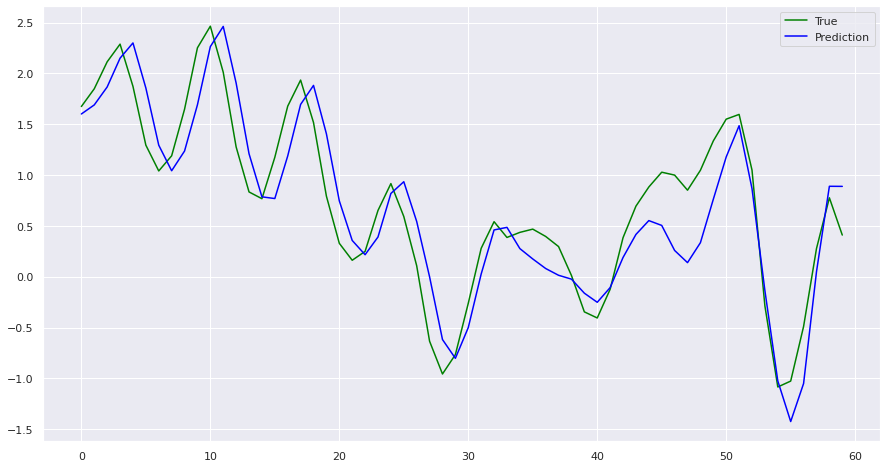

In [40]:
interpolation_plot(test_dataset, sequence_size, times=60)

<Figure size 1080x576 with 1 Axes>

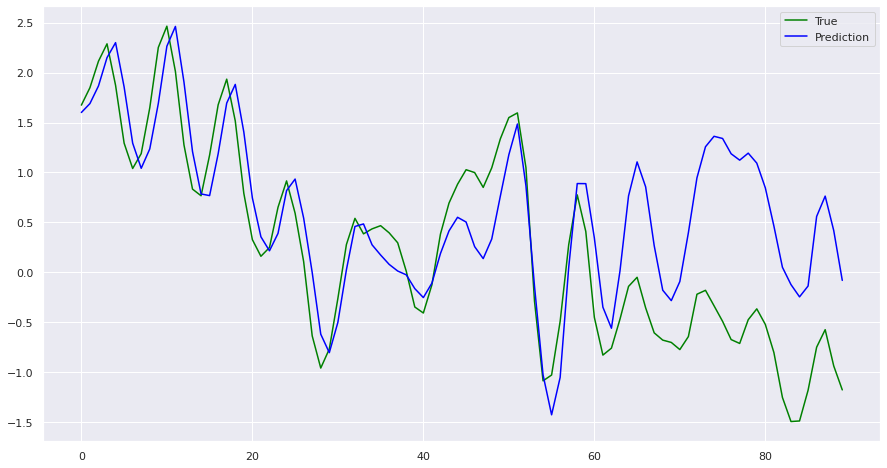

In [41]:
interpolation_plot(test_dataset, sequence_size, times=90)

<Figure size 1080x576 with 1 Axes>

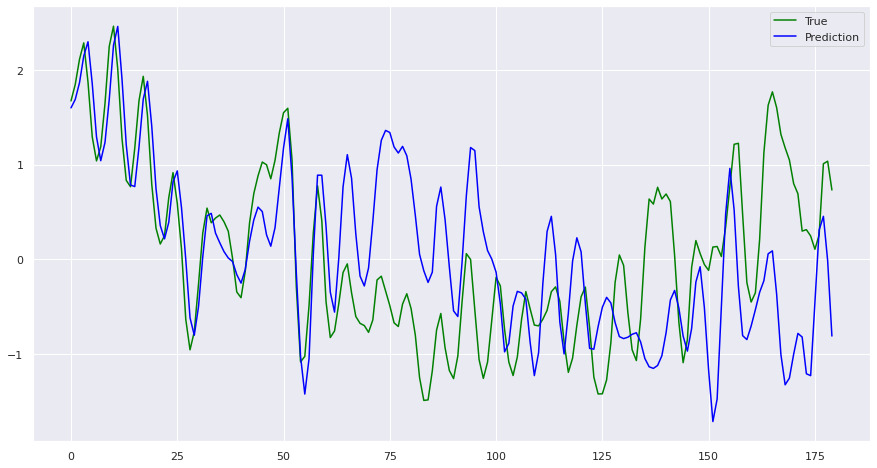

In [42]:
interpolation_plot(test_dataset, sequence_size, times=180)